In [ ]:
pwd

In [2]:
import numpy as np 
import pandas as pd
import ants

from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
from scipy.stats import pearsonr,spearmanr,kendalltau
from datetime import datetime;now = datetime.now
print(now())

2022-02-21 13:53:18.811245


In [3]:
df = pd.read_csv('../../Data/ABIDE_legend_S982.csv')
patients = df['DxGroup'].values==1
df_asd = df.iloc[patients]

In [4]:
subs = df_asd['BIDS_ID'].values

In [5]:
fn_temp = '../../../jacobians/normed_Js_masked/{}_normed_Js_masked.nii'

In [6]:
ims = [ants.image_read(fn_temp.format(sub)) for sub in tqdm(subs)]

100%|██████████| 470/470 [00:06<00:00, 75.39it/s]


In [7]:
flatmap = np.array([im.numpy().flatten() for im in ims]) 
evox = ((flatmap**2).sum(axis=0)!=0)
flatmap = flatmap[:,evox] # only analyze voxels with values > 0
flatmap = flatmap-flatmap.mean(axis=0) # center each voxel at zero
#flatmap = flatmap-flatmap.mean(axis=1)[:,np.newaxis] # center each subject at zero
flatmap.shape

(470, 55432)

In [8]:
mean_J = ims[0].new_image_like(np.array([im.numpy() for im in ims]).mean(axis=0))
mean_J.to_filename('meanJ.nii')

## OVERALL PCA

In [9]:
from sklearn.decomposition import PCA
reducer = PCA()
reducer.fit(flatmap)
j_pca_all = reducer.transform(flatmap)

In [10]:
# Components needed to explain %90 of variance
print((np.cumsum(reducer.explained_variance_ratio_)<.9).sum())

103


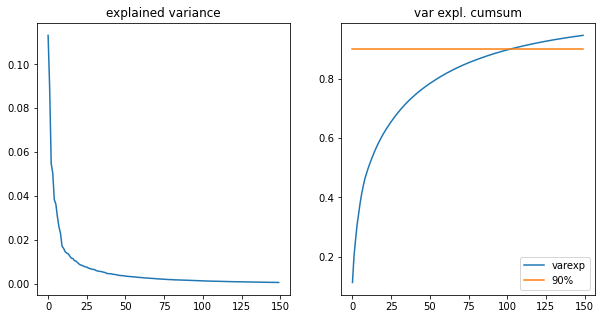

In [11]:
nplot = 150
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(reducer.explained_variance_ratio_[0:nplot])
plt.title('explained variance')
plt.subplot(1,2,2)
plt.plot(np.cumsum(reducer.explained_variance_ratio_[0:nplot]))
plt.plot(np.arange(nplot),np.repeat(.9,nplot))
plt.title('var expl. cumsum')
plt.legend(['varexp','90%'])

In [12]:
# LOSO PCA
est_pca = False
if est_pca:
    ns = flatmap.shape[0]
    j_pca_loso = np.array([PCA().fit(flatmap[np.arange(ns)!=s]).transform(flatmap[s,:][np.newaxis,:]) for s in tqdm(range(ns))])
    np.save(file='../../Data/j_pca_loso.npy',arr=j_pca_loso)
else:
    j_pca_loso = np.load('../../Data/j_pca_loso.npy')

j_pca_loso_2 = j_pca_loso[:,0,0:2]

In [13]:
j_pca = j_pca_loso_2

In [14]:
#from scipy.stats import pearsonr
#corr = kendalltau
corr = pearsonr

In [15]:
jacobians_flat = np.array([im.numpy().flatten() for im in ims])

In [16]:
# DO X AXIS
res = np.array([corr(jacobians_flat[:,v],j_pca[:,0]) for v in tqdm(range(jacobians_flat.shape[1]))])
xcorr_r = res[:,0]
xcorr_p = res[:,1]

  0%|          | 0/262144 [00:00<?, ?it/s]/data/aglinska/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

100%|██████████| 262144/262144 [00:05<00:00, 44872.66it/s]


In [17]:
# DO Y AXIS
res = np.array([corr(jacobians_flat[:,v],j_pca[:,1]) for v in tqdm(range(jacobians_flat.shape[1]))])
ycorr_r = res[:,0]
ycorr_p = res[:,1]

100%|██████████| 262144/262144 [00:05<00:00, 45462.49it/s]


In [18]:
# Runtime warning when correlating zero voxels, can ignore
#xcorr = np.array([np.corrcoef(jacobians_flat[:,v],j_pca[:,0])[0,1] for v in tqdm(range(jacobians_flat.shape[1]))])
#ycorr = np.array([np.corrcoef(jacobians_flat[:,v],j_pca[:,1])[0,1] for v in tqdm(range(jacobians_flat.shape[1]))])

In [19]:
# BONF CORRECT MAPS
xcorr_r_threshed = xcorr_r.copy()
ycorr_r_threshed = ycorr_r.copy()

p_thresh = .05/(~np.isnan(xcorr_p)).sum()
print(p_thresh)
#print(~np.isnan(xcorr_p).sum())

xcorr_r_threshed[xcorr_p>p_thresh]=np.nan
ycorr_r_threshed[ycorr_p>p_thresh]=np.nan

9.020060614807332e-07


In [20]:
(~np.isnan(xcorr_p)).sum()

55432

In [21]:
print((abs(xcorr_r_threshed[xcorr_p<p_thresh])).min())
print((abs(ycorr_r_threshed[ycorr_p<p_thresh])).min())

0.22427351112357402
0.2243131561658503


In [22]:
print((xcorr_r_threshed[xcorr_r_threshed<0].min().round(2),xcorr_r_threshed[xcorr_r_threshed<0].max().round(2)))
print((xcorr_r_threshed[xcorr_r_threshed>0].min().round(2),xcorr_r_threshed[xcorr_r_threshed>0].max().round(2)))

print((ycorr_r_threshed[ycorr_r_threshed<0].min().round(2),ycorr_r_threshed[ycorr_r_threshed<0].max().round(2)))
print((ycorr_r_threshed[ycorr_r_threshed>0].min().round(2),ycorr_r_threshed[ycorr_r_threshed>0].max().round(2)))

(-0.68, -0.22)
(0.22, 0.73)
(-0.64, -0.22)
(0.22, 0.74)


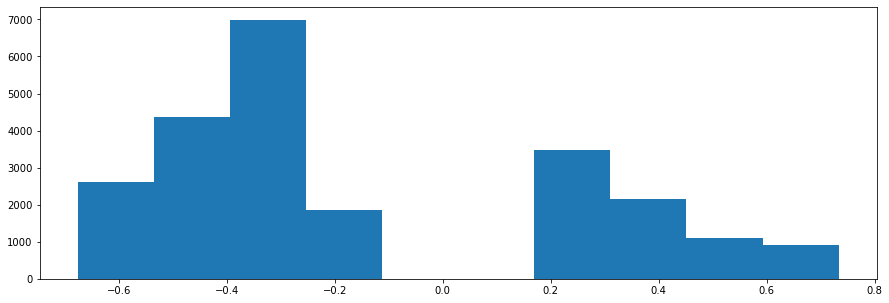

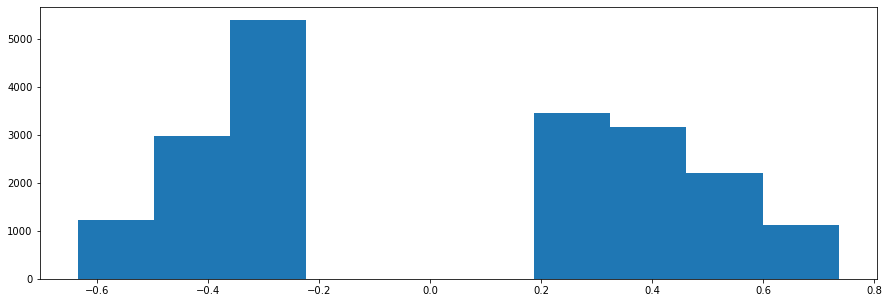

In [23]:
plt.figure(figsize=(15,5));
plt.hist(xcorr_r_threshed);

plt.figure(figsize=(15,5));
plt.hist(ycorr_r_threshed);

In [24]:
# plt.hist(xcorr_r_threshed[xcorr_p<p_thresh])
# plt.hist(ycorr_r_threshed[ycorr_p<p_thresh])

In [25]:
temp = ants.image_read('single_subj_T1.nii')
temp = temp.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)

In [26]:
xcorr_nii = ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64))) #.plot_ortho(flat=True,black_bg=True,cmap='bwr')
ycorr_nii = ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64))) #.plot_ortho(flat=True,black_bg=True,cmap='bwr')

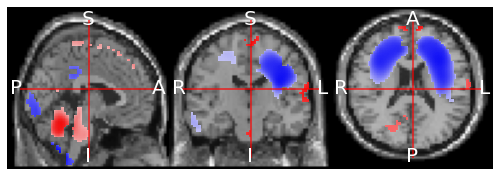

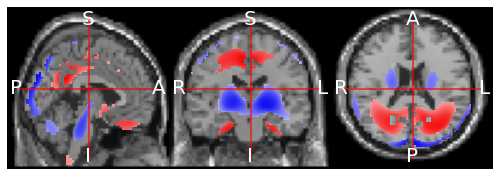

In [27]:
temp.plot_ortho(xcorr_nii,flat=True,black_bg=True,cmap='gray',overlay_cmap='bwr')
temp.plot_ortho(ycorr_nii,flat=True,black_bg=True,cmap='gray',overlay_cmap='bwr')

In [28]:
ycorr_r_threshed[np.isnan(ycorr_r_threshed)]=0
xcorr_r_threshed[np.isnan(xcorr_r_threshed)]=0

#ims[0].new_image_like(xcorr_r.reshape((64,64,64))).to_filename('xcorr_pearsonr.nii')
#ims[0].new_image_like(ycorr_r.reshape((64,64,64))).to_filename('ycorr_pearsonr.nii')

#ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64))).to_filename('xcorr-bonf_pearsonr.nii')
#ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64))).to_filename('ycorr-bonf_pearsonr.nii')

In [29]:
print(np.nanmin(xcorr_r).round(3),np.nanmean(xcorr_r).round(3),np.nanmax(xcorr_r).round(3))
print(np.nanmin(ycorr_r).round(3),np.nanmean(ycorr_r).round(3),np.nanmax(ycorr_r).round(3))

-0.676 -0.069 0.733
-0.636 0.001 0.736


## CORRELATE PCA W/ SYMPTOMS

In [30]:
# CORR PCA W/ SYMOTOMS
#corr = pearsonr
#corr = kendalltau

keys = ['AgeAtScan','FIQ','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh','ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB','ADI_R_Onset Total']
a = ['DSMIVTR','AgeAtScan', 'Sex', 'FIQ', 'VIQ', 'PIQ', 
        'ADOS_Total', 
       'ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB',
       'ADI_R_Onset Total', 'ADI_R_ResearchReliability',
        'ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh',
        'SRS_RawTotal', 'SRS_Version',
       'SCQ_Total', 'VINELAND_Receptive_Vscore', 'VINELAND_Expressive_Vscore',
       'VINELAND_Written_Vscore', 'VINELAND_CommunicationStandard',
       'VINELAND_Personal_Vscore', 'VINELAND_Domestic_Vscore',
       'VINELAND_Community_Vscore', 'VINELAND_DaylyLiving_Standard',
       'VINELAND_Interpersonal_Vscore', 'VINELAND_Play_Vscore',
       'VINELAND_Coping_Vscore', 'VINELAND_Socical_Standard',
       'VINELAND_Domestic_Standard', 'VINELAND_ABC_Standard',
     'ADOSGotham_SocAffect', 'ADOSGotham_Rest-RepBeh',
       'ADOSGotham_Total', 'ADOSGotham_Severity', 
       'AQ Total', 'SRS_awareness', 'SRS_cognition', 'SRS_communication',
       'SRS_motivation', 'SRS_manierisms']

keys = a
npcs = 2 # How many PCs
# Make dataframe
col1 = list()
col2 = list()
for key in keys:
    for i in ['r','p','df']:
        col1.append(key)
        col2.append(i)
#columns = [[key,key],['r','p']]
columns = [col1,col2]
res_corr = pd.DataFrame(np.zeros((npcs,len(col1))),columns=columns)

for key in keys:
    for pc in range(npcs):
        vec_behav = df[key].values[patients]
        #vec_pca = j_pca_loso[:,0,pc]
        vec_pca = j_pca[:,pc]
        e = np.isnan(vec_behav)
        r,p = corr(vec_behav[~e],vec_pca[~e])
        res_corr.loc[pc].at[(key,'r')] = r
        res_corr.loc[pc].at[(key,'p')] = p
        res_corr.loc[pc].at[(key,'df')] = len(vec_behav[~e])-2
        #res_corr.loc[pc].at[(key,'n')] = len(vec_behav[~e])

In [31]:
pd.options.display.max_columns = None
res_corr

DSMIVTR                  AgeAtScan                        Sex            \
          r         p     df         r         p     df         r         p   
0 -0.130817  0.005144  454.0  0.042556  0.357281  468.0  0.033063  0.474561   
1  0.040164  0.392186  454.0  0.042158  0.361798  468.0  0.012222  0.791565   

               FIQ                        VIQ                        PIQ  \
      df         r         p     df         r         p     df         r   
0  468.0  0.036195  0.455148  426.0 -0.003065  0.952014  386.0  0.081868   
1  468.0  0.037571  0.438180  426.0 -0.014529  0.775437  386.0  0.011024   

                   ADOS_Total                  ADI_R_SocialTotal            \
          p     df          r         p     df                 r         p   
0  0.107832  385.0   0.076945  0.140146  367.0          0.082370  0.147932   
1  0.828858  385.0   0.002570  0.960752  367.0         -0.042894  0.451741   

         ADI_R_VerbalTotal                  ADI_R_RRB                   \
      df                 r         p     df         r         p     df   
0  308.0          0.054716  0.336173  309.0 -0.068489  0.229204  308.0   
1  308.0          0.032587  0.566978  309.0 -0.043262  0.447862  308.0   

  ADI_R_Onset Total                  ADI_R_ResearchReliability            \
                  r         p     df                         r         p   
0          0.031480  0.597945  281.0                  0.073291  0.189583   
1          0.021753  0.715586  281.0                  0.024872  0.656572   

         ADOS_Comm                  ADOS_Social                  ADOS_StBeh  \
      df         r         p     df           r         p     df          r   
0  320.0  0.117008  0.030027  342.0    0.100223  0.062958  343.0   0.107814   
1  320.0  0.104545  0.052713  342.0   -0.041963  0.437192  343.0  -0.066280   

                   SRS_RawTotal                  SRS_Version                   \
          p     df            r         p     df           r         p     df   
0  0.069154  283.0     0.077245  0.289462  188.0    0.195124  0.034224  116.0   
1  0.264742  283.0    -0.027872  0.702668  188.0    0.114182  0.218261  116.0   

  SCQ_Total                 VINELAND_Receptive_Vscore                  \
          r         p    df                         r         p    df   
0 -0.001645  0.989218  68.0                 -0.178002  0.143387  67.0   
1  0.151658  0.210105  68.0                 -0.234862  0.052072  67.0   

  VINELAND_Expressive_Vscore                 VINELAND_Written_Vscore  \
                           r         p    df                       r   
0                  -0.150912  0.215802  67.0                0.026187   
1                  -0.284115  0.017986  67.0               -0.244732   

                  VINELAND_CommunicationStandard                  \
          p    df                              r         p    df   
0  0.830866  67.0                      -0.176889  0.145945  67.0   
1  0.042694  67.0                      -0.292164  0.014852  67.0   

  VINELAND_Personal_Vscore                 VINELAND_Domestic_Vscore            \
                         r         p    df                        r         p   
0                 -0.02990  0.807322  67.0                -0.011796  0.923362   
1                 -0.15777  0.195417  67.0                -0.102543  0.401784   

        VINELAND_Community_Vscore                  \
     df                         r         p    df   
0  67.0                 -0.070693  0.563792  67.0   
1  67.0                 -0.033879  0.782273  67.0   

  VINELAND_DaylyLiving_Standard                 VINELAND_Interpersonal_Vscore  \
                              r         p    df                             r   
0                     -0.045935  0.707816  67.0                      0.010360   
1                     -0.100722  0.410237  67.0                     -0.119419   

                  VINELAND_Play_Vscore                 VINELAND_Coping_Vscore  \
          p    df         

In [32]:
corr

<function scipy.stats.stats.pearsonr(x, y)>

In [33]:
these_keys = ['ADOS_Comm','ADOS_Social','ADOS_StBeh','AgeAtScan','Sex','FIQ']
for pc in range(res_corr.shape[0]):
    for key in these_keys:
        p = res_corr[key]['p'][pc]
        r = res_corr[key]['r'][pc]
        dgf = res_corr[key]['df'][pc]
        
        if p < 1:
            print(f'PC{pc} | {key} | $\\tau$({int(dgf)}) = {r:.2f}, p = {p:.3f}')
            #print('PC {} - {} | r = {:.3f},p = {:.3f}'.format(pc,key,res_corr[key]['r'][pc],res_corr[key]['p'][pc]))       
#             if p < .001:
#                 print('pc {}|{}| r({}) = {:.2f}, p = {:.3f}'.format(pc,key,int(res_corr[key]['df'][pc]),res_corr[key]['r'][pc],res_corr[key]['p'][pc]))            
#             else:
#                 print('pc {}|{}| r({}) = {:.2f}, p < .001'.format(pc,key,int(res_corr[key]['df'][pc]),res_corr[key]['r'][pc]))            


PC0 | ADOS_Comm | $\tau$(342) = 0.12, p = 0.030
PC0 | ADOS_Social | $\tau$(343) = 0.10, p = 0.063
PC0 | ADOS_StBeh | $\tau$(283) = 0.11, p = 0.069
PC0 | AgeAtScan | $\tau$(468) = 0.04, p = 0.357
PC0 | Sex | $\tau$(468) = 0.03, p = 0.475
PC0 | FIQ | $\tau$(426) = 0.04, p = 0.455
PC1 | ADOS_Comm | $\tau$(342) = 0.10, p = 0.053
PC1 | ADOS_Social | $\tau$(343) = -0.04, p = 0.437
PC1 | ADOS_StBeh | $\tau$(283) = -0.07, p = 0.265
PC1 | AgeAtScan | $\tau$(468) = 0.04, p = 0.362
PC1 | Sex | $\tau$(468) = 0.01, p = 0.792
PC1 | FIQ | $\tau$(426) = 0.04, p = 0.438


In [34]:
# print(f'{ages_comm.mean():.2f},{ages_comm.std():.2f},{ages_comm.min():.2f},{ages_comm.max():.2f}')
# print(f'{ages_gotham.mean():.2f},{ages_gotham.std():.2f},{ages_gotham.min():.2f},{ages_gotham.max():.2f}')

In [35]:
arr = np.array([res_corr[key]['r'].values for key in keys])

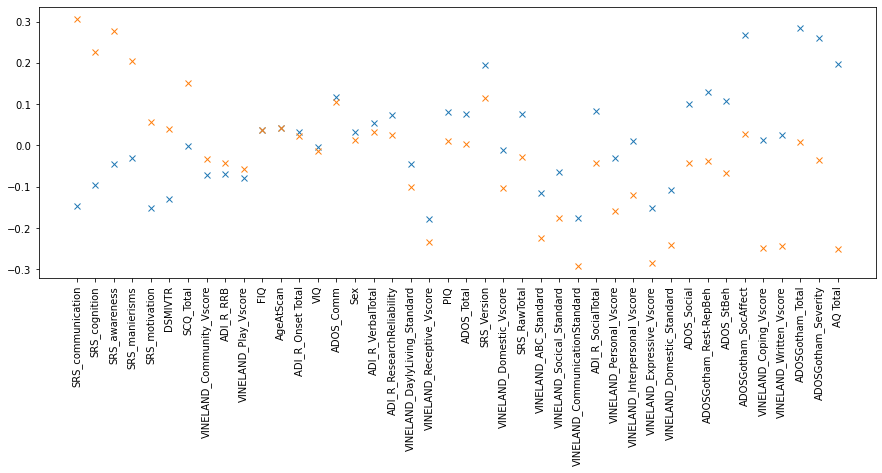

In [36]:
plt.figure(figsize=(15,5))
o = np.argsort(arr[:,0]-arr[:,1])
plt.plot(arr[o,:],'x')
plt.xticks(np.arange(len(o)),labels=np.array(keys)[o],rotation=90);

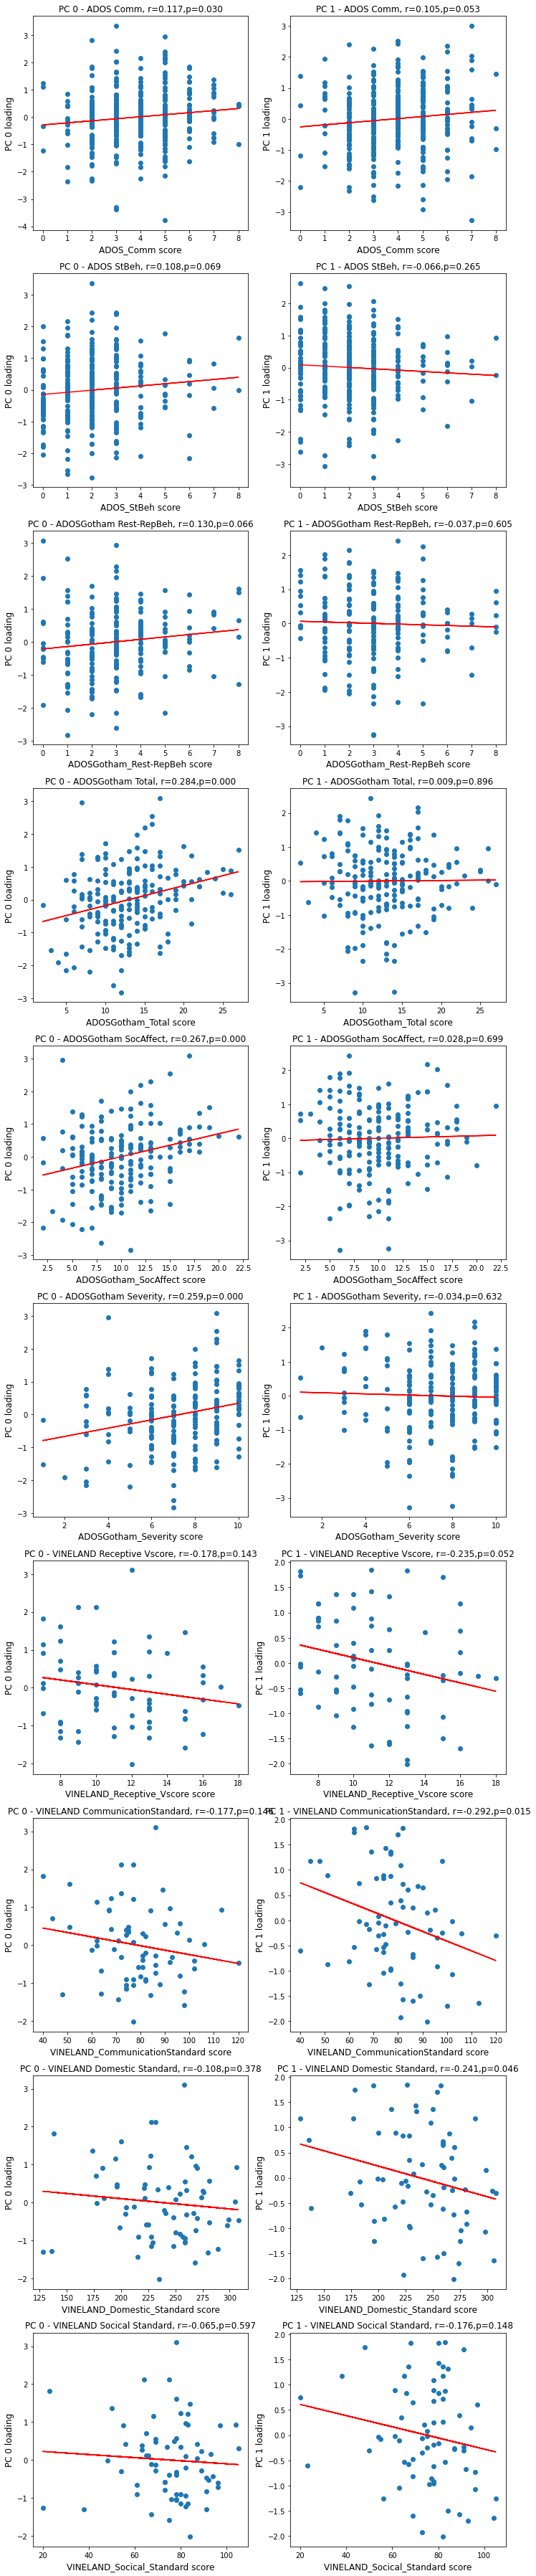

In [37]:
these_pcs = 2
these_keys = ['ADOS_Comm','ADOS_StBeh','ADOSGotham_Rest-RepBeh','ADOSGotham_Total','ADOSGotham_SocAffect','ADOSGotham_Severity'
             ,'VINELAND_Receptive_Vscore'
             ,'VINELAND_CommunicationStandard'
             ,'VINELAND_Domestic_Standard','VINELAND_Socical_Standard']

#these_keys = ['ADOS_Comm','ADOS_StBeh']

i = 0
plt.figure(figsize=(10,5*len(these_keys)))
for key in these_keys:
    for pc in range(these_pcs):
        i+=1
        plt.subplot(len(these_keys),2,i)
        vec_behav = df[key].values[patients]
        vec_pca = j_pca[:,pc]
        e = np.isnan(vec_behav)

        import scipy

        v1 = vec_behav[~e]
        v2 = j_pca[~e,pc]

        #v1 = scipy.stats.zscore(v1)
        v2 = scipy.stats.zscore(v2)

        x = v1
        y = v2
        m, b = np.polyfit(x,y, 1)
        plt.scatter(v1,v2)
        plt.plot(x, m*x + b,'r')
        plt.xlabel(f'{key} score',fontsize=12)
        plt.ylabel(f'PC {pc} loading',fontsize=12)

        rval = res_corr[key]['r'][pc]
        pval = res_corr[key]['p'][pc]
        this_key = key.replace('_',' ')
        plt.title(f'PC {pc} - {this_key}, r={rval:.3f},p={pval:.3f}')
        
plt.tight_layout()

In [38]:
# vec_behav = df['VINELAND_Socical_Standard'].values[patients]
# vec_behav[vec_behav<50]=np.nan
# vec_pca = j_pca[:,0]
# e = np.isnan(vec_behav)
# r,p = corr(vec_behav[~e],vec_pca[~e])

# v1 = vec_behav[~e]
# v2 = j_pca[~e,pc]

# #v1 = scipy.stats.zscore(v1)
# v2 = scipy.stats.zscore(v2)

# x = v1
# y = v2
# m, b = np.polyfit(x,y, 1)
# plt.scatter(v1,v2)
# plt.plot(x, m*x + b,'r')
# plt.xlabel(f'{key} score',fontsize=12)
# plt.ylabel(f'PC {pc} loading',fontsize=12)
# (r,p)

In [39]:
##

In [40]:
pwd

'/mmfs1/data/aglinska/BC-MRI-AE/misc/jacobian_pca'

In [41]:
c1 = ants.image_read('../../Data/c1Atlas_brain_2mm.nii').resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)
c2 = ants.image_read('../../Data/c2Atlas_brain_2mm.nii').resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)

In [42]:
xcorr_r_nii = ims[0].new_image_like(xcorr_r.reshape((64,64,64)))# .to_filename('xcorr.nii')
ycorr_r_nii = ims[0].new_image_like(ycorr_r.reshape((64,64,64)))# .to_filename('ycorr.nii')

xcorr_r_threshed_nii = ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64)))# .to_filename('xcorr-bonf.nii')
ycorr_r_threshed_nii = ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64)))# .to_filename('ycorr-bonf.nii')

In [43]:
xcorr_r_nii_nii_pos = xcorr_r_nii.copy()
xcorr_r_nii_nii_neg = xcorr_r_nii.copy()
xcorr_r_nii_nii_pos[xcorr_r_nii<0] = 0
xcorr_r_nii_nii_neg[xcorr_r_nii>0] = 0

ycorr_r_nii_nii_pos = ycorr_r_nii.copy()
ycorr_r_nii_nii_neg = ycorr_r_nii.copy()
ycorr_r_nii_nii_pos[ycorr_r_nii<0] = 0
ycorr_r_nii_nii_neg[ycorr_r_nii>0] = 0

xcorr_r_nii_nii_neg = xcorr_r_nii_nii_neg.new_image_like(abs(xcorr_r_nii_nii_neg.numpy()))
ycorr_r_nii_nii_neg = ycorr_r_nii_nii_neg.new_image_like(abs(ycorr_r_nii_nii_neg.numpy()))

xcorr_r_nii_nii_pos[np.isnan(xcorr_r_nii_nii_pos.numpy())] = 0
xcorr_r_nii_nii_neg[np.isnan(xcorr_r_nii_nii_neg.numpy())] = 0
ycorr_r_nii_nii_pos[np.isnan(ycorr_r_nii_nii_pos.numpy())] = 0
ycorr_r_nii_nii_neg[np.isnan(ycorr_r_nii_nii_neg.numpy())] = 0

#xcorr_r_nii_nii_pos.to_filename('pos-xcorr2.nii')
#xcorr_r_nii_nii_neg.to_filename('neg-xcorr2.nii')
#ycorr_r_nii_nii_pos.to_filename('pos-ycorr2.nii')
#ycorr_r_nii_nii_neg.to_filename('neg-ycorr2.nii')

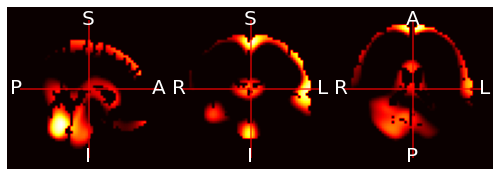

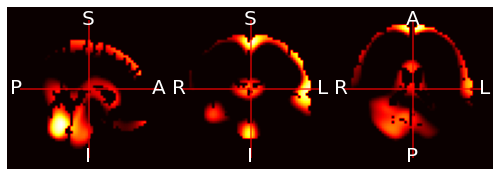

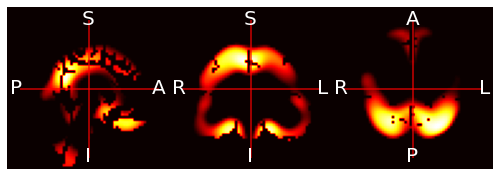

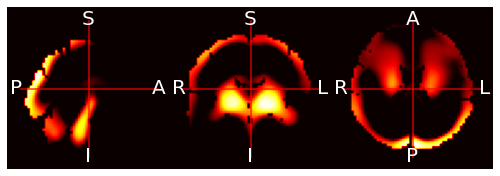

In [44]:
xcorr_r_nii_nii_pos.plot_ortho(flat=True,cmap='hot')
xcorr_r_nii_nii_pos.plot_ortho(flat=True,cmap='hot')

ycorr_r_nii_nii_pos.plot_ortho(flat=True,cmap='hot')
ycorr_r_nii_nii_neg.plot_ortho(flat=True,cmap='hot')

In [45]:
xcorr_r_threshed_nii_pos = xcorr_r_threshed_nii.copy()
xcorr_r_threshed_nii_neg = xcorr_r_threshed_nii.copy()
xcorr_r_threshed_nii_pos[xcorr_r_threshed_nii_pos<0] = 0
xcorr_r_threshed_nii_neg[xcorr_r_threshed_nii_neg>0] = 0

ycorr_r_threshed_nii_pos = ycorr_r_threshed_nii.copy()
ycorr_r_threshed_nii_neg = ycorr_r_threshed_nii.copy()
ycorr_r_threshed_nii_pos[ycorr_r_threshed_nii_pos<0] = 0
ycorr_r_threshed_nii_neg[ycorr_r_threshed_nii_neg>0] = 0


ycorr_r_threshed_nii_neg = ycorr_r_threshed_nii_neg.new_image_like(abs(ycorr_r_threshed_nii_neg.numpy()))
xcorr_r_threshed_nii_neg = xcorr_r_threshed_nii_neg.new_image_like(abs(xcorr_r_threshed_nii_neg.numpy()))

xcorr_r_threshed_nii_pos.to_filename('pos-xcorr_pearsonr.nii')
xcorr_r_threshed_nii_neg.to_filename('neg-xcorr-bonf_pearsonr.nii')
ycorr_r_threshed_nii_pos.to_filename('pos-ycorr-bonf_pearsonr.nii')
ycorr_r_threshed_nii_neg.to_filename('neg-ycorr-bonf_pearsonr.nii')

In [46]:
xcorr_r_threshed_gm_nii = xcorr_r_threshed_nii.copy()
xcorr_r_threshed_wm_nii = xcorr_r_threshed_nii.copy()

ycorr_r_threshed_gm_nii = ycorr_r_threshed_nii.copy()
ycorr_r_threshed_wm_nii = ycorr_r_threshed_nii.copy()

In [47]:
xcorr_r_threshed_gm_nii[c1<.9]=0
xcorr_r_threshed_wm_nii[c2<.9]=0

ycorr_r_threshed_gm_nii[c1<.9]=0
ycorr_r_threshed_wm_nii[c2<.9]=0

In [48]:
xcorr_r_threshed_gm_nii.to_filename('xcorr-bonf-gm_pearsonr.nii')
xcorr_r_threshed_wm_nii.to_filename('xcorr-bonf-wm_pearsonr.nii')

ycorr_r_threshed_gm_nii.to_filename('ycorr-bonf-gm_pearsonr.nii')
ycorr_r_threshed_wm_nii.to_filename('ycorr-bonf-wm_pearsonr.nii')

In [49]:
ants.__version__

'0.2.4'

In [50]:
print(now())

2022-02-21 13:53:47.352478
